<a href="https://colab.research.google.com/github/Ryandry1st/Machine-Learning/blob/master/Compressive_Sensing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [0]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as spopt
import scipy.fftpack as spfft
import scipy.ndimage as spimg
import cvxpy as cvx

%matplotlib inline
plt.rcParams["figure.figsize"] = (10,10)

64 samples taken
NR =  4000
Minimum samples for NR =  11.0
8 samples selected


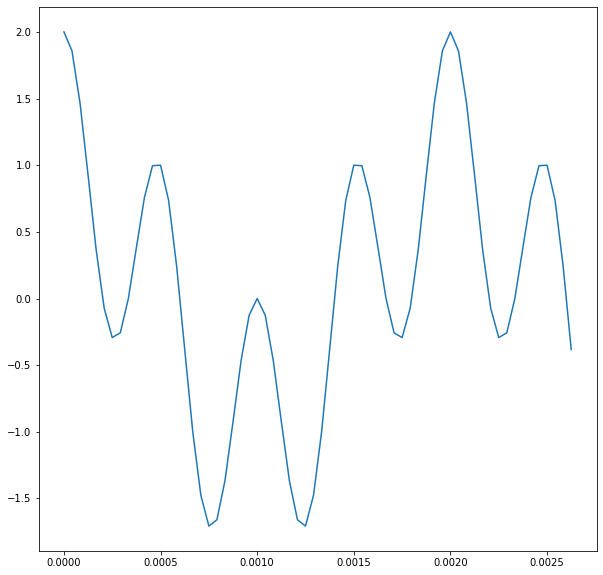

In [0]:
# Setup of signal and sampling parameters
f1 = 2000
f2 = 500
fs1 = 24e3
fs2 = 3000
n = 64
npx = 2**21

tend = n/fs1
m = int(tend*fs2)
f = np.linspace(0, fs1, n)
f = np.linspace(0, fs1, npx)


# initial signal
t = np.linspace(0, (n-1)/fs1, n)
x = np.cos(2*f1*np.pi*t)+np.cos(2*f2*np.pi*t)
# DCT of the signal
xf = np.fft.fft(x, n=npx, norm="ortho")
plt.plot(t, x)

print(n, "samples taken")
print("NR = ", max(f1, f2)*2)
print("Minimum samples for NR = ", np.ceil((max(f1, f2)*2)*tend))
print(m, "samples selected")
# print("Minimum samples for ideal CS =", np.ceil(m/np.log(n/m)))

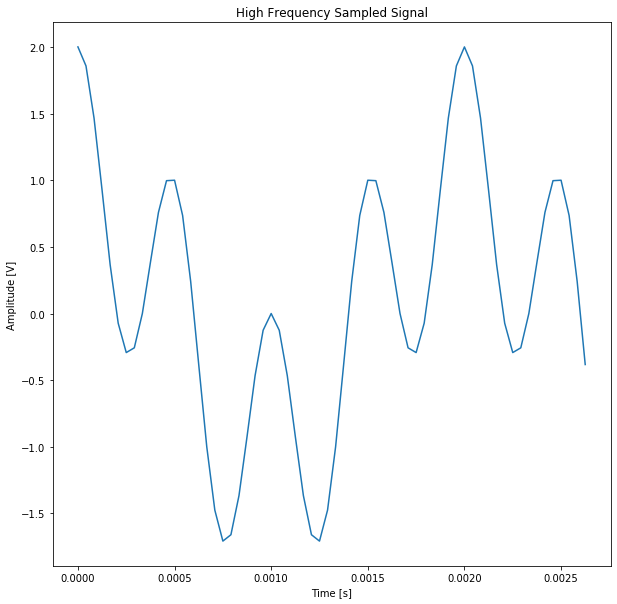

In [0]:
plt.plot(t, x)
#plt.xlim(0, 0.05)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude [V]")
plt.title("High Frequency Sampled Signal")
plt.show()

2027.6308191446396


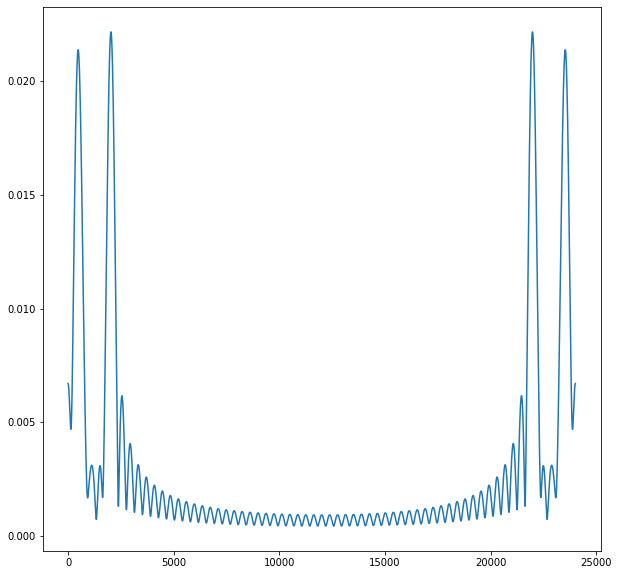

In [0]:
plt.plot(f, np.abs(xf))
idx = np.argmax(np.abs(xf))
print(f[idx])

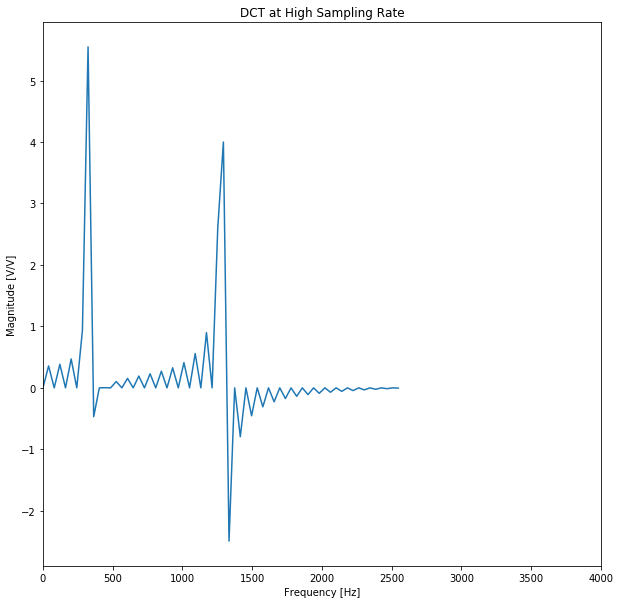

In [0]:
plt.plot(f/(np.pi), xf)
plt.xlim(0, max(f1, f2)*2)
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude [V/V]")
plt.title("DCT at High Sampling Rate")
plt.show()

In [0]:
print(t)

[0.       0.000125 0.00025  0.000375 0.0005   0.000625 0.00075  0.000875
 0.001    0.001125 0.00125  0.001375 0.0015   0.001625 0.00175  0.001875
 0.002    0.002125 0.00225  0.002375 0.0025   0.002625 0.00275  0.002875
 0.003    0.003125 0.00325  0.003375 0.0035   0.003625 0.00375  0.003875
 0.004    0.004125 0.00425  0.004375 0.0045   0.004625 0.00475  0.004875
 0.005    0.005125 0.00525  0.005375 0.0055   0.005625 0.00575  0.005875
 0.006    0.006125 0.00625  0.006375 0.0065   0.006625 0.00675  0.006875
 0.007    0.007125 0.00725  0.007375 0.0075   0.007625 0.00775  0.007875]


(0, 12566.370614359172)

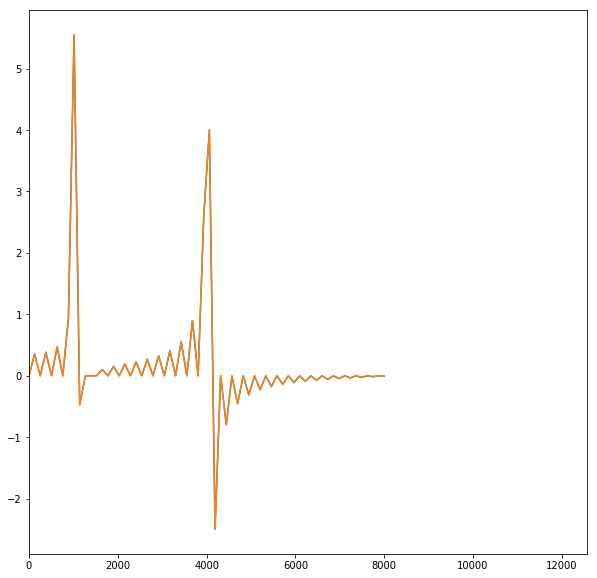

In [0]:
def transform(vector):
    if vector.ndim != 1:
        raise ValueError()
    n = vector.size
    if n == 1:
        return vector.copy()
    elif n == 0 or n % 2 != 0:
        raise ValueError()
    else:
        #print("n = ", n)
        half = n // 2
        gamma = vector[ : half]
        delta = vector[n - 1 : half - 1 : -1]
        #print("gamma = ", len(gamma))
        #print("delta = ", len(delta))
        #print(gamma+delta)
        alpha = transform(gamma + delta)
        #print(gamma - delta)
        beta  = transform((gamma - delta) / (np.cos(np.arange(0.5, half + 0.5) * (np.pi / n)) * 2.0))
        result = np.zeros_like(vector)
        result[0 : : 2] = alpha
        result[1 : : 2] = beta
        #print(alpha)
        #print(beta)
        #print(beta[1 : ])
        #print(result)
        result[1 : n - 1 : 2] += beta[1 : ]
        return result


# DCT type III, unscaled. Algorithm by Byeong Gi Lee, 1984.
# See: https://www.nayuki.io/res/fast-discrete-cosine-transform-algorithms/lee-new-algo-discrete-cosine-transform.pdf
def inverse_transform(vector, root=True):
    if vector.ndim != 1:
        raise ValueError()
    if root:
        vector = vector.copy()
        vector[0] /= 2.0
    n = vector.size
    if n == 1:
        return vector
    elif n == 0 or n % 2 != 0:
        raise ValueError()
    else:
        half = n // 2
        alpha = vector[0 : : 2].copy()
        beta  = vector[1 : : 2].copy()
        beta[1 : ] += vector[1 : n - 1 : 2]
        inverse_transform(alpha, False)
        inverse_transform(beta , False)
        beta /= np.cos(np.arange(0.5, half + 0.5) * (np.pi / n)) * 2.0
        vector[ : half] = alpha + beta
        vector[n - 1 : half - 1 : -1] = alpha - beta
        return vector

  
xf2 = transform(x)*np.sqrt((2/n))

plt.plot(f, xf2, f, xf)
plt.xlim(0, max(f1, f2)*2*np.pi)

In [0]:
choice = 0
ri = np.array([], dtype=int)
print(int(n/m), n+1, int(n/m))
if(choice == 1):
    for i in range(int(np.ceil(n/m)), n+1, int(n/m)):
        ri = np.append(ri, np.random.randint(i-int(np.ceil(n/m)), i))

else:
    ri = np.random.choice(n, m, replace=False) # random sample of indices
    ri.sort() # sorting not strictly necessary, but convenient for plotting
    
t2 = t[ri]
y = x[ri]


print(len(ri))
print(ri)

2 65 2
24
[ 1  2  7 12 14 15 16 18 19 20 25 29 32 37 42 45 47 48 50 51 54 55 58 60]


(0, 0.005)

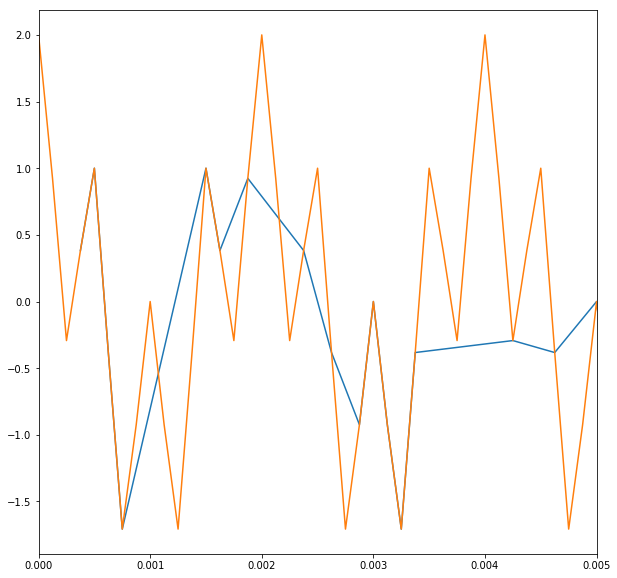

In [0]:
plt.plot(t2, y, t, x)
plt.xlim(0, 0.005)

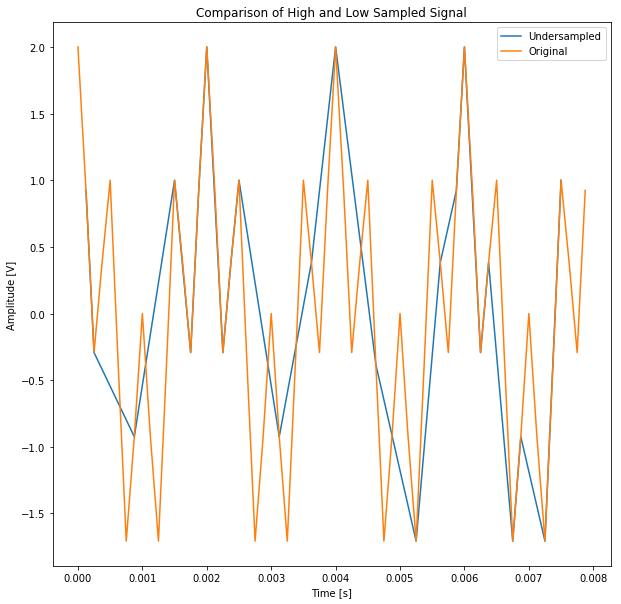

In [0]:
plt.plot(t2, y, t, x)
#plt.xlim(0, 0.05)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude [V]")
plt.title("Comparison of High and Low Sampled Signal")
plt.legend(['Undersampled', 'Original'], loc=1)
plt.show()

In [0]:
A = spfft.idct(np.identity(n), norm='ortho', axis=0)
A.shape

(64, 64)

In [0]:
A = A[ri]
A[1:].shape

(23, 64)

In [0]:
#L1 optimization

vx = cvx.Variable(n)
obj = cvx.Minimize(cvx.norm(vx, 1))
const = [A*vx==y]
prob = cvx.Problem(obj, const)
result = prob.solve(verbose=1)

-----------------------------------------------------------------
           OSQP v0.5.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2018
-----------------------------------------------------------------
problem:  variables n = 128, constraints m = 152
          nnz(P) + nnz(A) = 1792
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on

iter   objective    pri res    dua res    rho        time
   1  -5.1200e+02   8.00e+00   8.24e+03   1.00e-01   1.46e-03s
 200   1.8569e+01   7.94e-03   2.07e-03   1.00e-01   4.80e-03s
 225   1.8581e+01   7.25e-03   1.13e-03   1.00e-01   5.34e-03s

(64,)


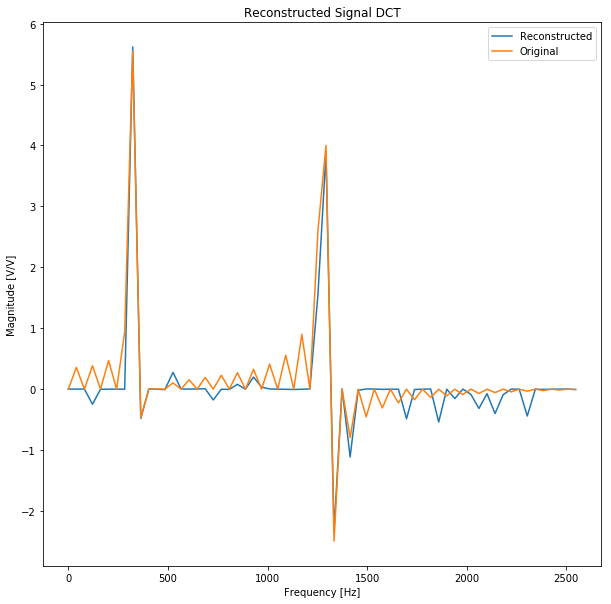

In [0]:
guess = np.array(vx.value)
print(guess.shape)
#guess = np.squeeze(guess)
plt.plot(f/np.pi, guess, f/np.pi, xf)
#plt.xlim(1000, 15000)
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude [V/V]")
plt.title("Reconstructed Signal DCT")
plt.legend(['Reconstructed', 'Original'], loc=1)
plt.show()

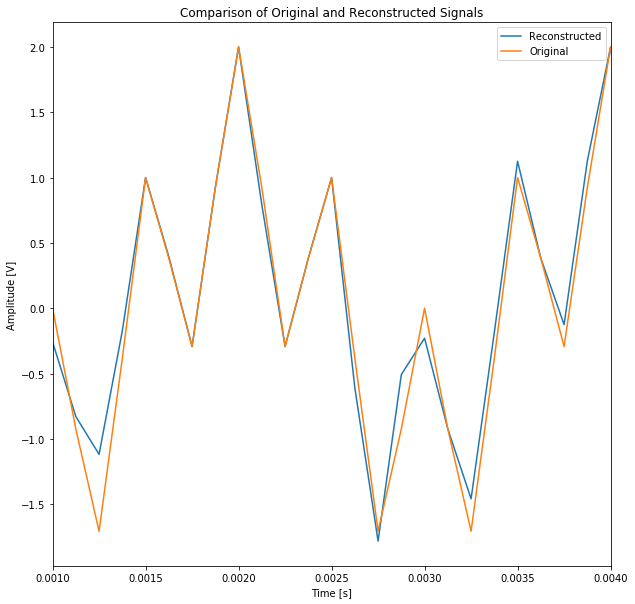

In [0]:
new = inverse_transform(guess)*np.sqrt((2/n))
plt.plot(t, new, t, x)
plt.xlim(0.001, 0.004)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude [V]")
plt.title("Comparison of Original and Reconstructed Signals")
plt.legend(['Reconstructed', 'Original'], loc=1)
plt.show()